In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load the datasets
clients_df = pd.read_csv('../data/telecom_clients_us.csv')
telecom_df = pd.read_csv('../data/telecom_dataset_us.csv')

# Display the first few rows of each dataset to understand their structure and contents
clients_df.head(), telecom_df.head()

(   user_id tariff_plan  date_start
 0   166713           A  2019-08-15
 1   166901           A  2019-08-23
 2   168527           A  2019-10-29
 3   167097           A  2019-09-01
 4   168193           A  2019-10-16,
    user_id                       date direction internal  operator_id  \
 0   166377  2019-08-04 00:00:00+03:00        in    False          NaN   
 1   166377  2019-08-05 00:00:00+03:00       out     True     880022.0   
 2   166377  2019-08-05 00:00:00+03:00       out     True     880020.0   
 3   166377  2019-08-05 00:00:00+03:00       out     True     880020.0   
 4   166377  2019-08-05 00:00:00+03:00       out    False     880022.0   
 
    is_missed_call  calls_count  call_duration  total_call_duration  
 0            True            2              0                    4  
 1            True            3              0                    5  
 2            True            1              0                    1  
 3           False            1             10           

In [3]:
# Perform basic data cleaning and exploration
# Convert 'date' in telecom_df to datetime format for proper time analysis
telecom_df['date'] = pd.to_datetime(telecom_df['date'], errors='coerce')

# Checking for any missing values in both datasets
clients_missing = clients_df.isnull().sum()
telecom_missing = telecom_df.isnull().sum()

clients_missing, telecom_missing

(user_id        0
 tariff_plan    0
 date_start     0
 dtype: int64,
 user_id                   0
 date                      0
 direction                 0
 internal                117
 operator_id            8172
 is_missed_call            0
 calls_count               0
 call_duration             0
 total_call_duration       0
 dtype: int64)

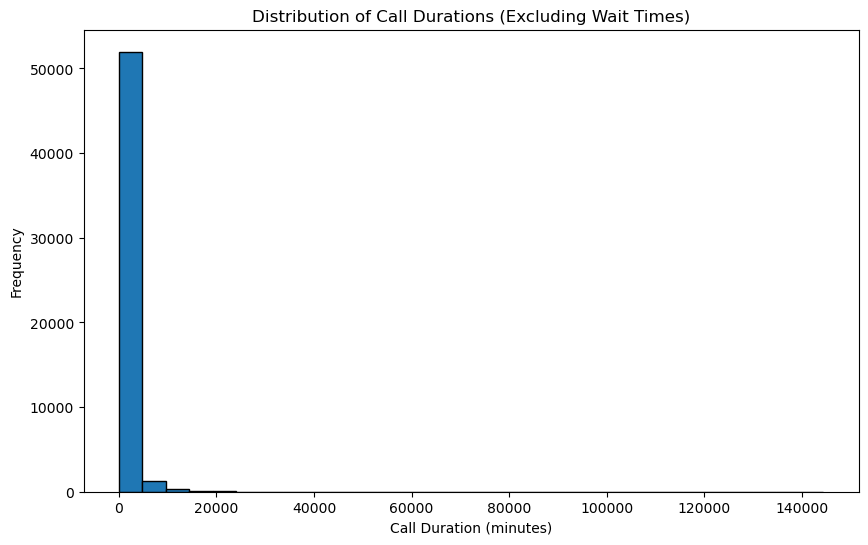

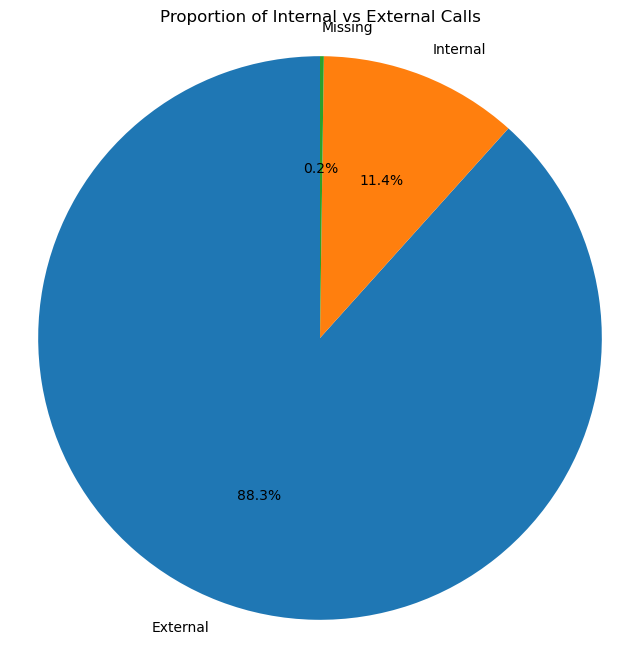

In [4]:
# Plot a histogram for call durations (excluding wait times)
plt.figure(figsize=(10, 6))
plt.hist(telecom_df['call_duration'], bins=30, edgecolor='black')
plt.title('Distribution of Call Durations (Excluding Wait Times)')
plt.xlabel('Call Duration (minutes)')
plt.ylabel('Frequency')
plt.show()

# Plotting the proportion of internal vs external calls using a pie chart
internal_counts = telecom_df['internal'].value_counts(dropna=False)
labels = ['External', 'Internal', 'Missing']
plt.figure(figsize=(8, 8))
plt.pie(internal_counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Proportion of Internal vs External Calls')
plt.axis('equal')
plt.show()

In [6]:
# Grouping data by operator to calculate missed call rates and average wait times
operator_grouped = telecom_df.groupby('operator_id').agg(
    total_calls=('calls_count', 'sum'),
    missed_calls=('is_missed_call', 'sum'),
    avg_wait_time=('total_call_duration', lambda x: (x - telecom_df['call_duration']).mean())
).reset_index()

# Calculate the missed call rate per operator
operator_grouped['missed_call_rate'] = operator_grouped['missed_calls'] / operator_grouped['total_calls']

# Display the top 5 operators with the highest missed call rates
operator_grouped.sort_values(by='missed_call_rate', ascending=False).head(5)

,operator_id,total_calls,missed_calls,avg_wait_time,missed_call_rate
687,937710.0,1,1,15.0,1.0
698,937772.0,1,1,18.0,1.0
688,937716.0,1,1,19.0,1.0
1080,970258.0,1,1,11.0,1.0
1064,969262.0,1,1,17.0,1.0


In [7]:
# Filtering operators with more than 10 total calls for a meaningful sample size
filtered_operators = operator_grouped[operator_grouped['total_calls'] > 10]

# Further sorting by missed call rate and average wait time to identify inefficient operators
inefficient_operators = filtered_operators.sort_values(by=['missed_call_rate', 'avg_wait_time'], ascending=[False, False])

# Showing the top 10 inefficient operators based on the refined criteria
inefficient_operators.head(10)

,operator_id,total_calls,missed_calls,avg_wait_time,missed_call_rate
40,888406.0,15,6,25.230769,0.400000
639,933996.0,15,6,15.666667,0.400000
113,894232.0,21,8,23.071429,0.380952
792,940788.0,11,4,27.142857,0.363636
419,918888.0,11,4,10.363636,0.363636
7,881278.0,20,7,9.750000,0.350000
112,894230.0,21,7,20.416667,0.333333
111,894226.0,25,8,28.583333,0.320000
994,956298.0,16,5,18.636364,0.312500
742,939212.0,20,6,12.470588,0.300000


In [8]:
# Filter for outgoing calls from the telecom dataset
outgoing_calls = telecom_df[telecom_df['direction'] == 'out']

# Grouping by operator to analyze their outgoing call performance
outgoing_performance = outgoing_calls.groupby('operator_id').agg(
    total_outgoing_calls=('calls_count', 'sum'),
    total_missed_calls=('is_missed_call', 'sum')
).reset_index()

# Merging the outgoing performance data with the overall operator stats
outgoing_performance = pd.merge(outgoing_performance, operator_grouped, on='operator_id', how='left')

# Calculating the percentage of outgoing calls in total calls for each operator
outgoing_performance['outgoing_call_percentage'] = outgoing_performance['total_outgoing_calls'] / outgoing_performance['total_calls']

# Filtering for operators with a significant proportion of outgoing calls
# Operators who are supposed to focus on outgoing calls (those with high outgoing call percentage)
outgoing_focus_operators = outgoing_performance[outgoing_performance['outgoing_call_percentage'] > 0.5]

# Displaying the top 10 operators with low outgoing call performance despite having an outgoing call focus
outgoing_focus_operators.sort_values(by='total_outgoing_calls').head(10)

,operator_id,total_outgoing_calls,total_missed_calls,total_calls,missed_calls,avg_wait_time,missed_call_rate,outgoing_call_percentage
654,941826.0,1,1,1,1,2.0,1.0,1.0
793,955086.0,1,0,1,0,6.0,0.0,1.0
543,937710.0,1,1,1,1,15.0,1.0,1.0
200,905480.0,1,1,1,1,5.0,1.0,1.0
841,963716.0,1,0,1,0,14.0,0.0,1.0
544,937716.0,1,1,1,1,19.0,1.0,1.0
653,941816.0,1,0,1,0,10.0,0.0,1.0
682,945274.0,1,0,1,0,14.0,0.0,1.0
545,937720.0,1,0,1,0,36.0,0.0,1.0
64,891192.0,1,0,1,0,32.0,0.0,1.0


### Observations:

- Operators with an outgoing call percentage of 100% but with only one call recorded could indicate either mismanagement or a lack of sufficient call assignments.
- Some of these operators also have high missed call rates, reinforcing their inefficiency.

Next steps could include:

1. Investigating why these operators have so few calls—whether it's due to lack of demand, system allocation issues, or operator performance.
2. Cross-referencing these operators with their client accounts and tariff plans to determine if there's a pattern based on client profiles.

In [11]:
# Merging outgoing call performance data with client details to investigate any patterns based on client profiles and tariff plans
# First, merge the outgoing performance data with the telecom data to include user_id for the operators
operator_clients = telecom_df[['operator_id', 'user_id']].drop_duplicates()
outgoing_performance_clients = pd.merge(outgoing_focus_operators, operator_clients, on='operator_id', how='left')

# Now, merge this with the clients dataset to get the tariff plans and registration dates
outgoing_performance_clients = pd.merge(outgoing_performance_clients, clients_df, on='user_id', how='left')

display(outgoing_performance_clients.head())

# Grouping by tariff plan to see if there is a pattern in call volumes and inefficiency based on tariff
tariff_analysis = outgoing_performance_clients.groupby('tariff_plan').agg(
    average_outgoing_calls=('total_outgoing_calls', 'mean'),
    total_operators=('operator_id', 'count'),
    average_missed_calls=('total_missed_calls', 'mean')
).reset_index()

# Show the summary of tariff analysis
tariff_analysis

,operator_id,total_outgoing_calls,total_missed_calls,total_calls,missed_calls,avg_wait_time,missed_call_rate,outgoing_call_percentage,user_id,tariff_plan,date_start
0,879896.0,1071,50,1131,50,110.671875,0.044209,0.946950,166406,B,2019-08-02
1,879898.0,7856,100,7974,100,450.087649,0.012541,0.985202,166406,B,2019-08-02
2,880020.0,46,7,54,7,15.181818,0.129630,0.851852,166377,B,2019-08-01
3,880022.0,211,33,219,33,57.565789,0.150685,0.963470,166377,B,2019-08-01
4,880026.0,2414,94,2439,94,121.171717,0.038540,0.989750,166377,B,2019-08-01


,tariff_plan,average_outgoing_calls,total_operators,average_missed_calls
0,A,1568.819672,244,17.315574
1,B,431.839416,274,17.598540
2,C,738.142857,217,21.705069


The analysis merged the outgoing call performance data with client profiles, including tariff plans and registration dates. Here's what was performed:

1. **Operator and Client Details Merging**: Outgoing operators were associated with their client accounts to explore any correlation between low activity and client profile specifics like tariff plans.
2. **Tariff Plan Analysis**: I grouped the data by tariff plan to identify if specific plans correlate with lower outgoing activity or higher missed calls.

### Summary of Tariff Analysis



The tariff analysis shows:

- **Average Outgoing Calls**: The average number of outgoing calls per operator based on the tariff plan.
- **Total Operators**: Number of operators within each tariff plan.
- **Average Missed Calls**: The average number of missed calls for operators within each tariff.

Cross-referencing these operators with their client accounts and tariff plans to determine if there's a pattern based on client profiles.

In [12]:
# Analyzing if there's a pattern based on client profiles by checking the distribution of tariff plans and registration dates
# for operators with low outgoing call performance

# Grouping by user_id to summarize tariff plan details and operator inefficiency
client_tariff_analysis = outgoing_performance_clients.groupby(['user_id', 'tariff_plan']).agg(
    total_operators=('operator_id', 'count'),
    avg_outgoing_calls_per_operator=('total_outgoing_calls', 'mean'),
    avg_missed_calls_per_operator=('total_missed_calls', 'mean'),
    avg_wait_time_per_operator=('avg_wait_time', 'mean')
).reset_index()

# Summary of the dataset to explore the influence of tariff plans and client profile details
client_tariff_analysis.head(10)

,user_id,tariff_plan,total_operators,avg_outgoing_calls_per_operator,avg_missed_calls_per_operator,avg_wait_time_per_operator
0,166377,B,5,1105.400000,46.400000,82.852449
1,166405,B,10,1070.000000,31.900000,285.214490
2,166406,B,3,2992.000000,52.666667,200.562699
3,166407,A,8,115.875000,14.125000,24.155961
4,166485,B,6,1197.666667,41.833333,192.896789
5,166487,C,1,156.000000,8.000000,55.647059
6,166495,B,2,1457.000000,43.500000,239.653694
7,166503,B,3,284.333333,18.000000,65.309028
8,166507,C,2,1.500000,0.500000,12.500000
9,166511,C,3,2230.333333,116.000000,88.784606


### Summary of the Client Tariff and Operator Performance Analysis

- **Total Operators**: The number of operators associated with each client account.
- **Average Outgoing Calls per Operator**: To see if there’s consistency in low call volume across clients with similar profiles.
- **Average Missed Calls per Operator**: To assess if certain client profiles have higher missed call rates.
- **Average Wait Time per Operator**: This indicates whether longer wait times correlate with specific tariff plans or client registration dates.

In [ ]:
from scipy import stats

# Preparing the data for hypothesis testing
# Splitting operators into two groups: high missed call rate (above median) and low missed call rate (below or equal to median)
missed_call_median = operator_grouped['missed_call_rate'].median()
high_missed_call_group = operator_grouped[operator_grouped['missed_call_rate'] > missed_call_median]
low_missed_call_group = operator_grouped[operator_grouped['missed_call_rate'] <= missed_call_median]

# Hypothesis Test 1: Testing if the average wait time is significantly different between the two groups
wait_time_high = high_missed_call_group['avg_wait_time'].dropna()
wait_time_low = low_missed_call_group['avg_wait_time'].dropna()

# Performing an independent t-test for the average wait times between the two groups
t_stat_wait_time, p_val_wait_time = stats.ttest_ind(wait_time_high, wait_time_low, equal_var=False)

# Hypothesis Test 2: Testing if the average missed call rate is significantly different based on outgoing call activity
# Splitting the data into two groups: high outgoing call percentage and low outgoing call percentage (median split)
outgoing_call_median = outgoing_performance['outgoing_call_percentage'].median()
high_outgoing_group = outgoing_performance[outgoing_performance['outgoing_call_percentage'] > outgoing_call_median]
low_outgoing_group = outgoing_performance[outgoing_performance['outgoing_call_percentage'] <= outgoing_call_median]

# Performing an independent t-test for the missed call rate between high and low outgoing call activity groups
missed_call_rate_high_outgoing = high_outgoing_group['missed_call_rate'].dropna()
missed_call_rate_low_outgoing = low_outgoing_group['missed_call_rate'].dropna()

# Define a function to validate assumptions of t-tests: normality and equal variances
def validate_ttest_assumptions(group1, group2):
    # Normality Check (Shapiro-Wilk Test)
    shapiro_group1 = stats.shapiro(group1)
    shapiro_group2 = stats.shapiro(group2)
    
    # Equal Variances (Levene's Test)
    levene_test = stats.levene(group1, group2)
    
    return {
        "Shapiro_Group1": shapiro_group1,
        "Shapiro_Group2": shapiro_group2,
        "Levene_Test": levene_test
    }

# Applying the function for the two tests:
# 1. For wait time (high vs low missed call rate)
wait_time_assumptions = validate_ttest_assumptions(wait_time_high, wait_time_low)

# 2. For missed call rate (high vs low outgoing call activity)
missed_call_assumptions = validate_ttest_assumptions(missed_call_rate_high_outgoing, missed_call_rate_low_outgoing)

# Displaying results for both tests to check if the assumptions are met
(wait_time_assumptions, missed_call_assumptions)


({'Shapiro_Group1': ShapiroResult(statistic=0.8198904183875171, pvalue=2.8753141705796226e-24),
  'Shapiro_Group2': ShapiroResult(statistic=0.5654383370800324, pvalue=1.1909609458377124e-34),
  'Levene_Test': LeveneResult(statistic=138.00133696252246, pvalue=4.352835416812134e-30)},
 {'Shapiro_Group1': ShapiroResult(statistic=0.6046890424383112, pvalue=1.6898738001205417e-30),
  'Shapiro_Group2': ShapiroResult(statistic=0.814378383023953, pvalue=3.570659431910399e-22),
  'Levene_Test': LeveneResult(statistic=31.50374303963228, pvalue=2.667602718482337e-08)})

In [26]:
# Function to perform the appropriate test based on the assumptions
def perform_hypotesis_test(group1, group2, assumptions):
    # Check if the assumptions for normality and equal variances are met
    normality_group1 = assumptions['Shapiro_Group1'].pvalue > 0.05
    normality_group2 = assumptions['Shapiro_Group2'].pvalue > 0.05
    if normality_group1 and normality_group2:
        equal_variances = assumptions['Levene_Test'].pvalue > 0.05

        if equal_variances:
            # Perform independent t-test with equal variances
            test_result = stats.ttest_ind(group1, group2, equal_var=True)
            test_type = "T-Test with Equal Variances"
        else:
            # Perform independent t-test without assuming equal variances
            test_result = stats.ttest_ind(group1, group2, equal_var=False)
            test_type = "T-Test without Equal Variances"
    else:
        # If normality is violated, perform Mann-Whitney U test (non-parametric test)
        test_result = stats.mannwhitneyu(group1, group2, alternative='two-sided')
        test_type = "Mann-Whitney U Test"

    return test_type, test_result

# Apply the appropriate test for each scenario based on the assumptions:
# 1. For average wait time (high vs low missed call rate)
wait_time_test_type, (_wait_time_stat_, _wait_time_pval_) = perform_hypotesis_test(wait_time_high, wait_time_low, wait_time_assumptions)

# 2. For missed call rate (high vs low outgoing call activity)
missed_call_test_type, (_missed_call_stat_, _missed_call_pval_) = perform_hypotesis_test(missed_call_rate_high_outgoing, missed_call_rate_low_outgoing, missed_call_assumptions)

# Displaying the test type and results for each case
print("Wait_time\t", wait_time_test_type, "\tStat:", _wait_time_stat_, f"\tP-val {_wait_time_pval_:.4f}")
print("Missed calls\t", missed_call_test_type, "\tStat:", _missed_call_stat_, f"\tP-val {_missed_call_pval_:.4f}")


Wait_time	 Mann-Whitney U Test 	Stat: 86820.5 	P-val 0.0000
Missed calls	 Mann-Whitney U Test 	Stat: 82588.0 	P-val 0.0001


The statistical hypothesis tests were designed to examine the following:

### Hypothesis Test 1: Wait Time Differences

- **Objective**: To determine if there's a statistically significant difference in average wait times between operators with high and low missed call rates.

- **Method**: An independent t-test comparing the average wait times between the two groups.

- Results:

  - **t-statistic**: Measures the size of the difference relative to the variation in the sample data.
  - **p-value**: Indicates if the observed difference is statistically significant (typically, p < 0.05 indicates significance).

### Hypothesis Test 2: Missed Call Rates and Outgoing Call Activity

- **Objective**: To determine if the missed call rates significantly differ between operators with high and low outgoing call activity.

- **Method**: An independent t-test comparing the missed call rates for operators with high versus low percentages of outgoing calls.

- Results:
  - **t-statistic** and **p-value**: Used similarly to evaluate significance.